In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

In [94]:
def update_calendar(cutoff):
    calendar_update = calendar.iloc[:cutoff, :]
    calendar_dates = calendar_update[['date', 'd']]
    calendar_dates = calendar_dates.set_index('d')
    return calendar_dates

In [143]:
calendar_updates = update_calendar(1913)
sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_dept = sales_train.groupby(['dept_id']).sum()
sales_train_cat.loc['TOTAL']= sales_train_cat.sum()
sales_train_cat_food = sales_train_cat.iloc[0, :].T
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_household = sales_train_cat.iloc[2, :].T
sales_train_cat_all = sales_train_cat.iloc[3, :].T

sales_train_dept_food1 = sales_train_dept.iloc[0, :].T
sales_train_dept_food2 = sales_train_dept.iloc[1, :].T
sales_train_dept_food3 = sales_train_dept.iloc[2, :].T
sales_train_dept_hobbies1 = sales_train_dept.iloc[3, :].T
sales_train_dept_hobbies2 = sales_train_dept.iloc[4, :].T
sales_train_dept_household1 = sales_train_dept.iloc[5, :].T
sales_train_dept_household2 = sales_train_dept.iloc[6, :].T

In [144]:
sales_train_dept = sales_train.groupby(['dept_id']).sum()

In [145]:
def drop_christmas(series):
    df = calendar[['date', 'd']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['month'] = df.index.month
    df['day'] = df.index.day
    month_mask = df['month'] == 12
    day_mask = df['day'] == 25
    df = df[month_mask & day_mask]
    df = df.drop(columns = ['month', 'day'])
    df['date'] = df.index
    df = df.set_index('d')
    lst = df.index.tolist()
    return series.drop(index = lst)

sales_train_cat_food = drop_christmas(sales_train_cat_food)
sales_train_cat_hobbies = drop_christmas(sales_train_cat_hobbies)
sales_train_cat_household = drop_christmas(sales_train_cat_household)
sales_train_cat_all = drop_christmas(sales_train_cat_all)
sales_train_dept_food1 = drop_christmas(sales_train_dept_food1)
sales_train_dept_food2 = drop_christmas(sales_train_dept_food2)
sales_train_dept_food3 = drop_christmas(sales_train_dept_food3)
sales_train_dept_hobbies1 = drop_christmas(sales_train_dept_hobbies1)
sales_train_dept_hobbies2 = drop_christmas(sales_train_dept_hobbies2)
sales_train_dept_household1 = drop_christmas(sales_train_dept_household1)
sales_train_dept_household2 = drop_christmas(sales_train_dept_household2)

In [146]:
def make_date_time(Series):
    df = pd.DataFrame(Series)
    df1 = df.join(calendar_dates)
    df1['date'] = pd.to_datetime(df1['date'])
    df1 = df1.set_index('date')
    return df1

big_food = make_date_time(sales_train_cat_food)
big_hobby = make_date_time(sales_train_cat_hobbies)
big_household = make_date_time(sales_train_cat_household)
big_all = make_date_time(sales_train_cat_all)
med_food1 = make_date_time(sales_train_dept_food1)
med_food2 = make_date_time(sales_train_dept_food2)
med_food3 = make_date_time(sales_train_dept_food3)
med_hobby1 = make_date_time(sales_train_dept_hobbies1)
med_hobby2 = make_date_time(sales_train_dept_hobbies2)
med_household1 = make_date_time(sales_train_dept_household1)
med_household2 = make_date_time(sales_train_dept_household2)

In [98]:
#To make a graph with a linear trendline
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)
    
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)    
    
# To make a detrended graph
def detrended_graph(Series):
    python_series = Series
    python_linear_trend = fit_linear_trend(python_series)
    python_series_detrended = python_series - python_linear_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(python_series_detrended.index, python_series_detrended)
    ax.set_title("Walmart Total Food Sales Detrended")
    plt.tight_layout()
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

In [99]:
def create_monthly_dummies(series):
    i = series.index.interval
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(i).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series, interval='month'):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)
    
#fig, ax = plt.subplots(figsize=(14, 5))
#plot_seasonal_trend(ax, 'hobbies', df1)
#plt.tight_layout()

In [100]:
def deseasonalize(Series):
    series = Series.iloc[:, 0]
    seasonal_trend = fit_seasonal_trend(Series)
    easonal_detrended = series - seasonal_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(Series.index, _seasonal_detrended)
    ax.set_title(f'Walmart {list(Series)[0]} Sales, Deseasonalized')

In [101]:
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.iloc[:-1, :]
    return df

In [102]:
def plot_seasonal_decomposition(axs, series):
    sd = sm.tsa.seasonal_decompose(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

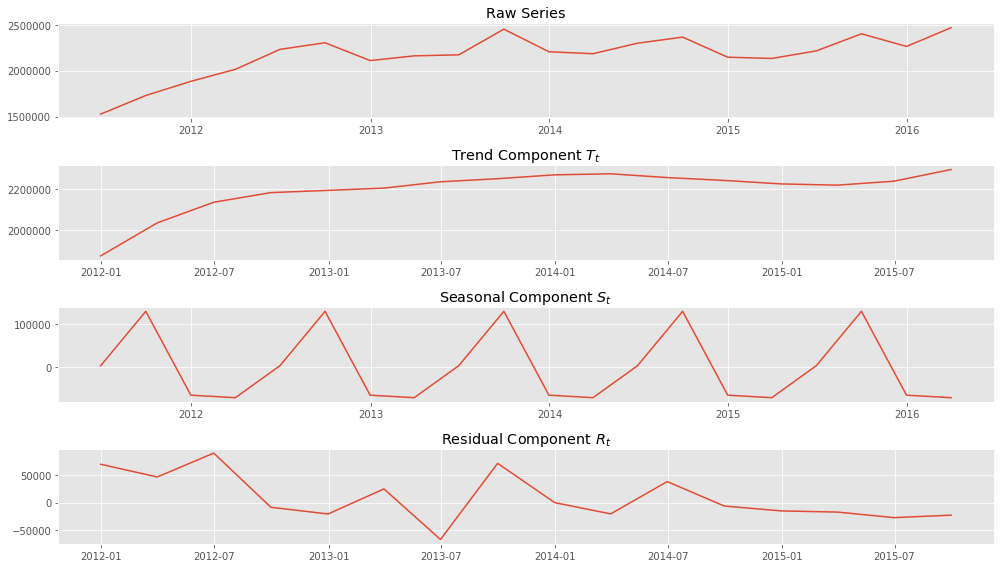

In [103]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_food, 'Q'))
plt.tight_layout()

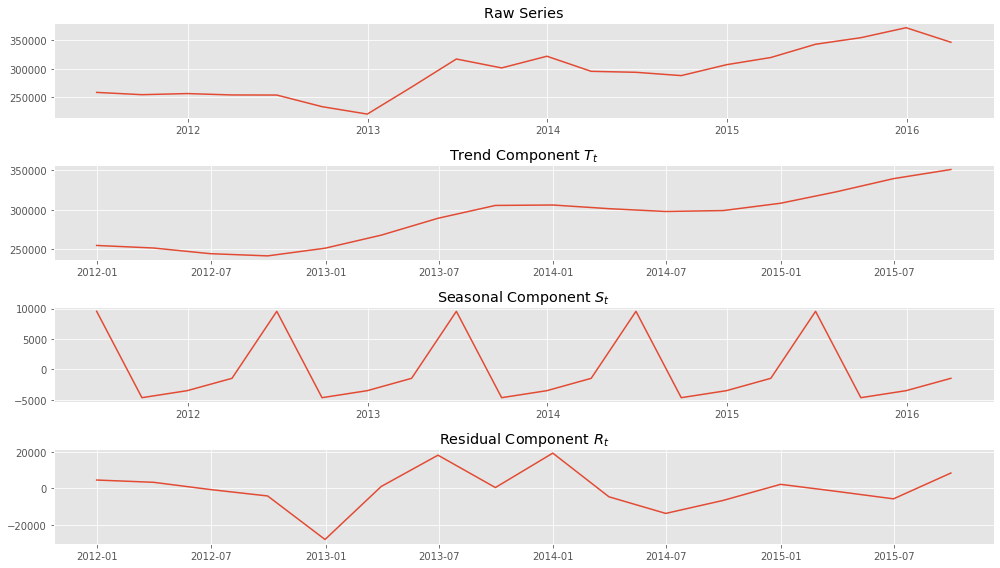

In [104]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_hobby, 'Q'))
plt.tight_layout()

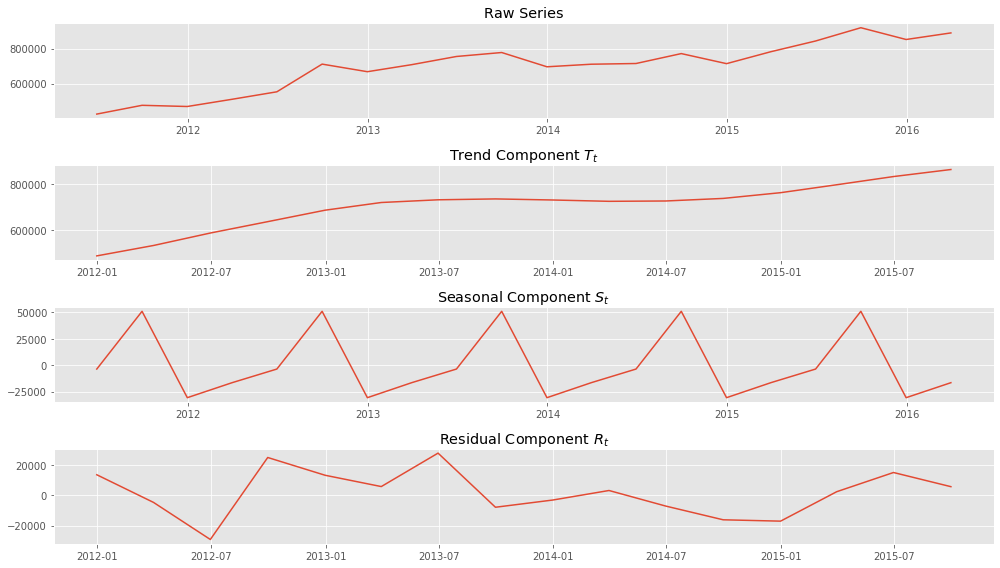

In [105]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_household, 'Q'))
plt.tight_layout()

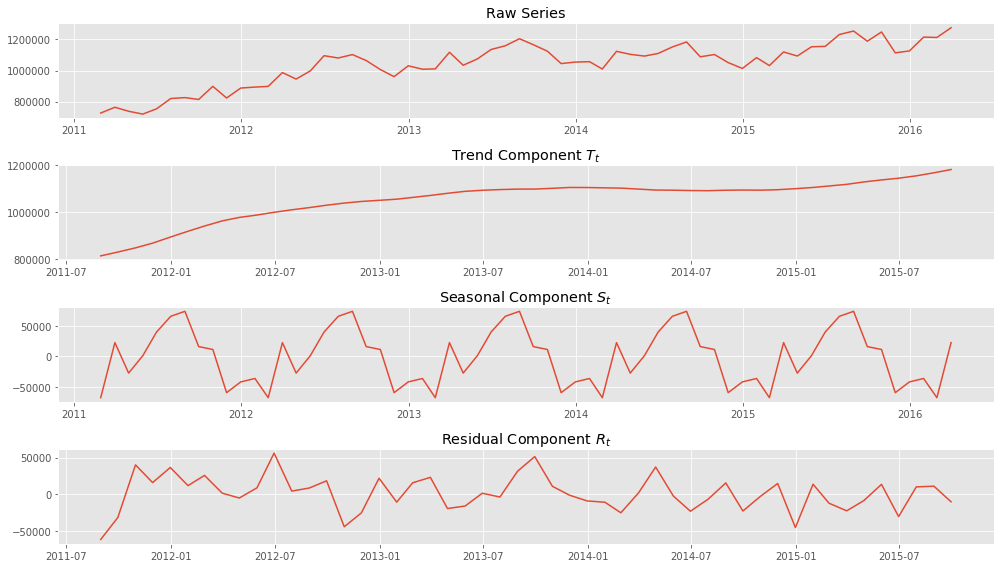

In [135]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_all, 'M'))
plt.tight_layout()

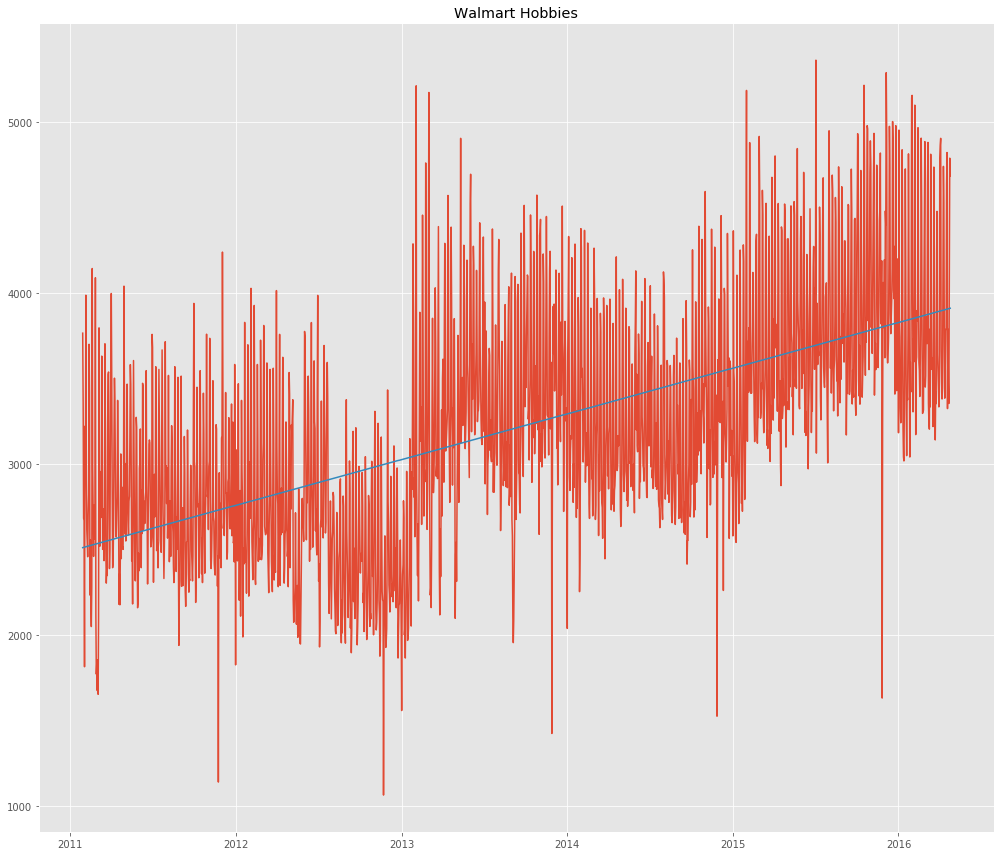

In [106]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Hobbies', big_hobby)
plt.tight_layout()

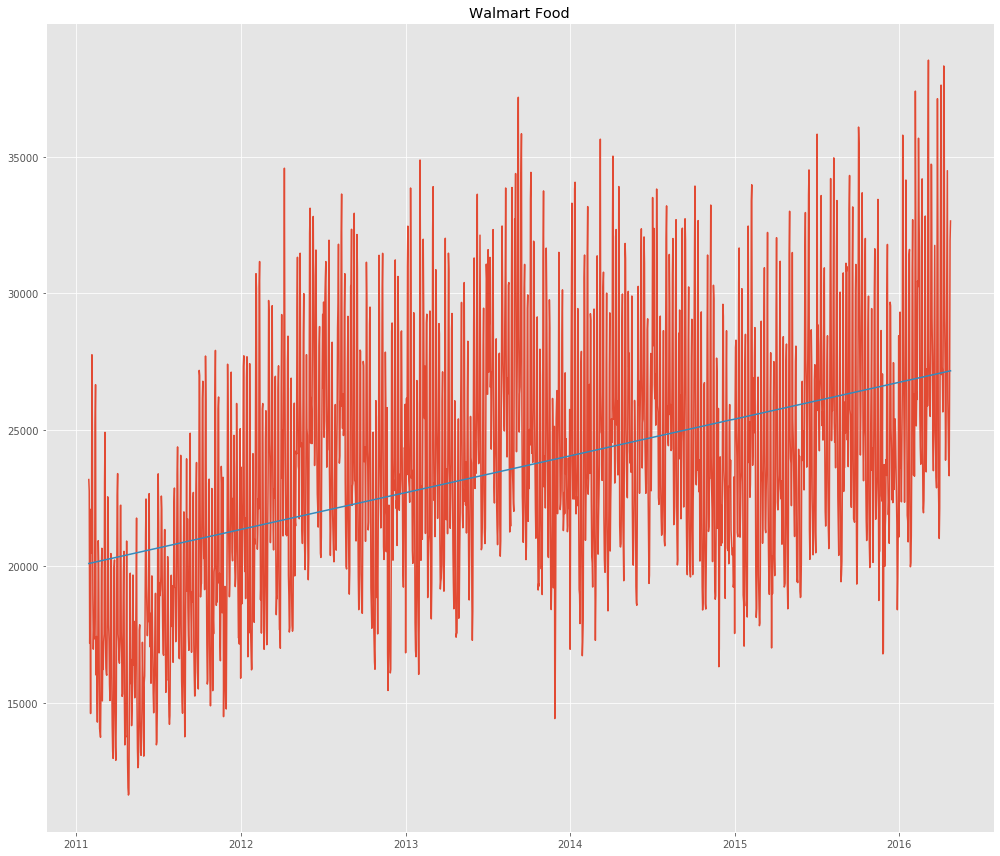

In [107]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Food', big_food)
plt.tight_layout()

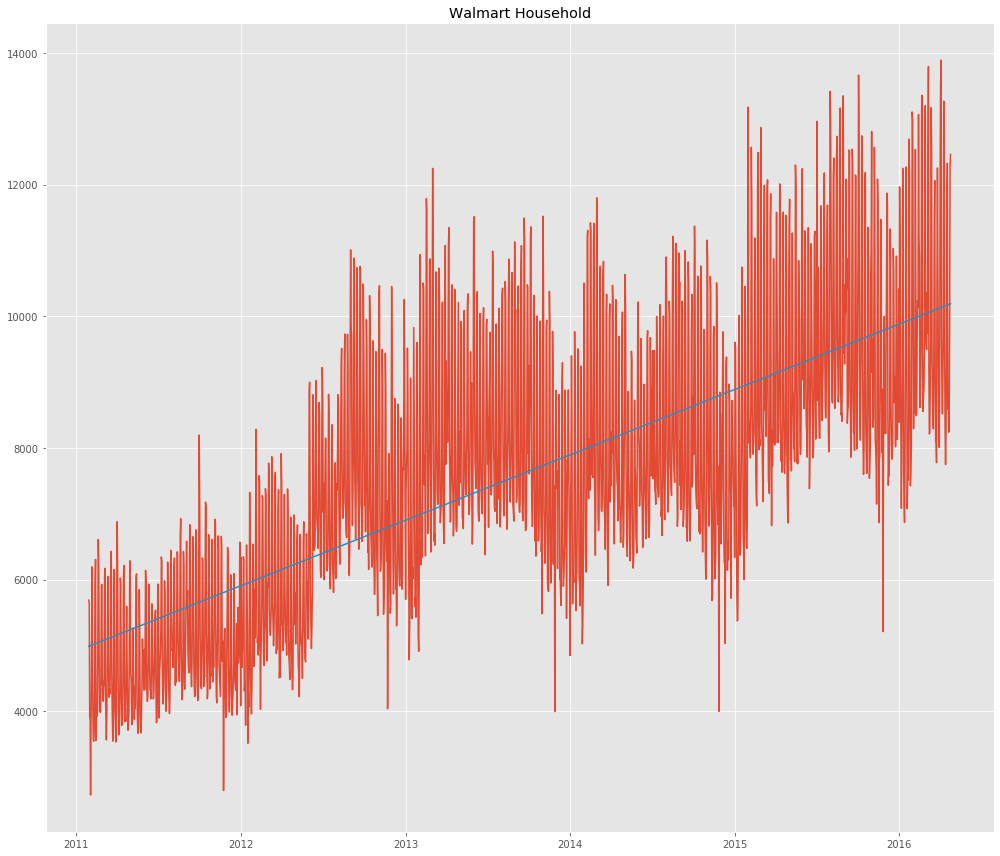

In [108]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Household', big_household)
plt.tight_layout()

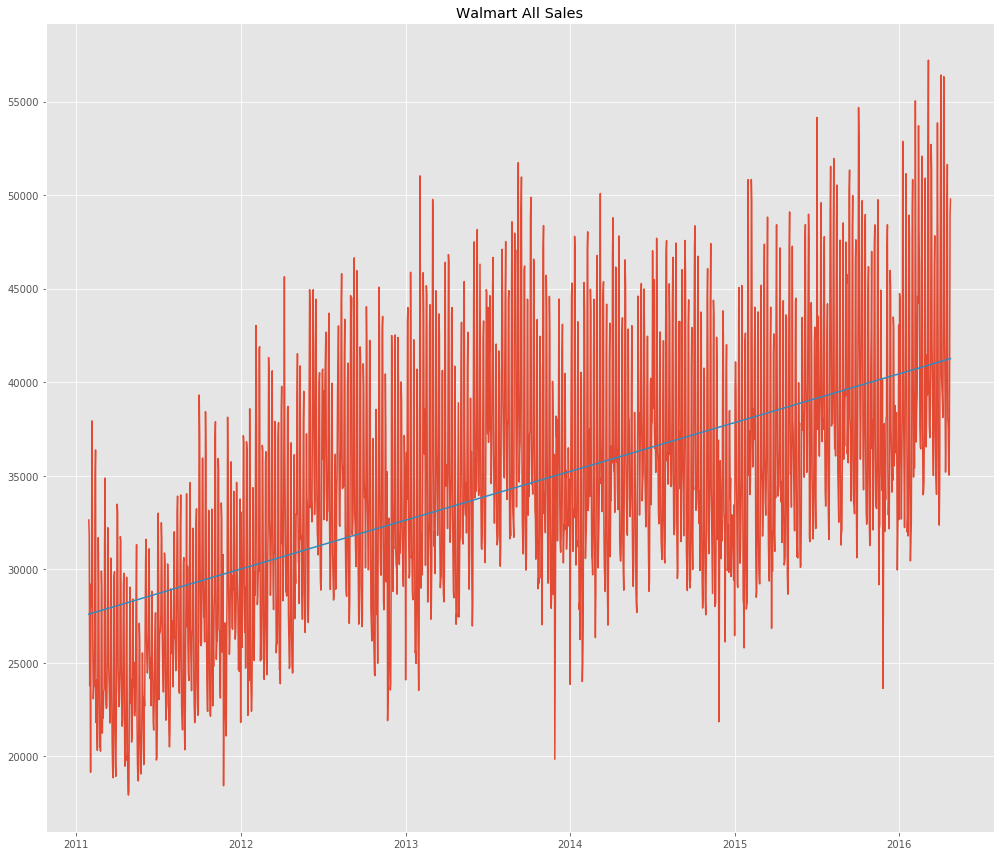

In [133]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart All Sales', big_all)
plt.tight_layout()

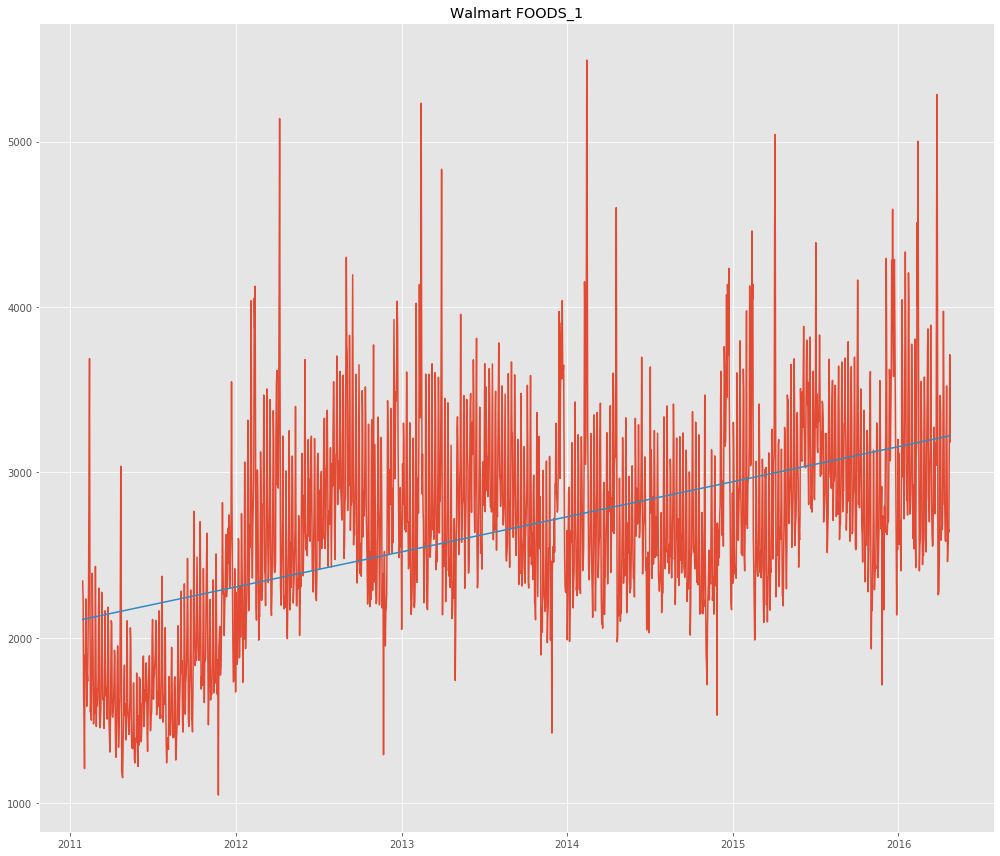

In [154]:
series = med_food1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

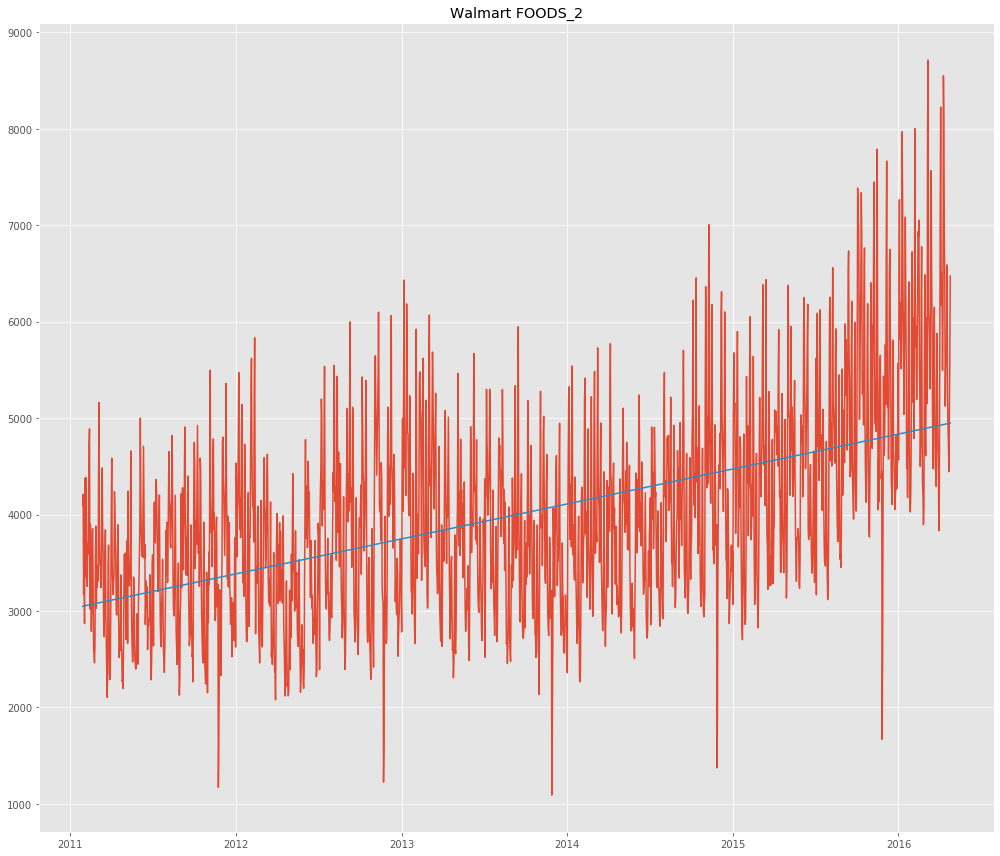

In [153]:
series = med_food2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

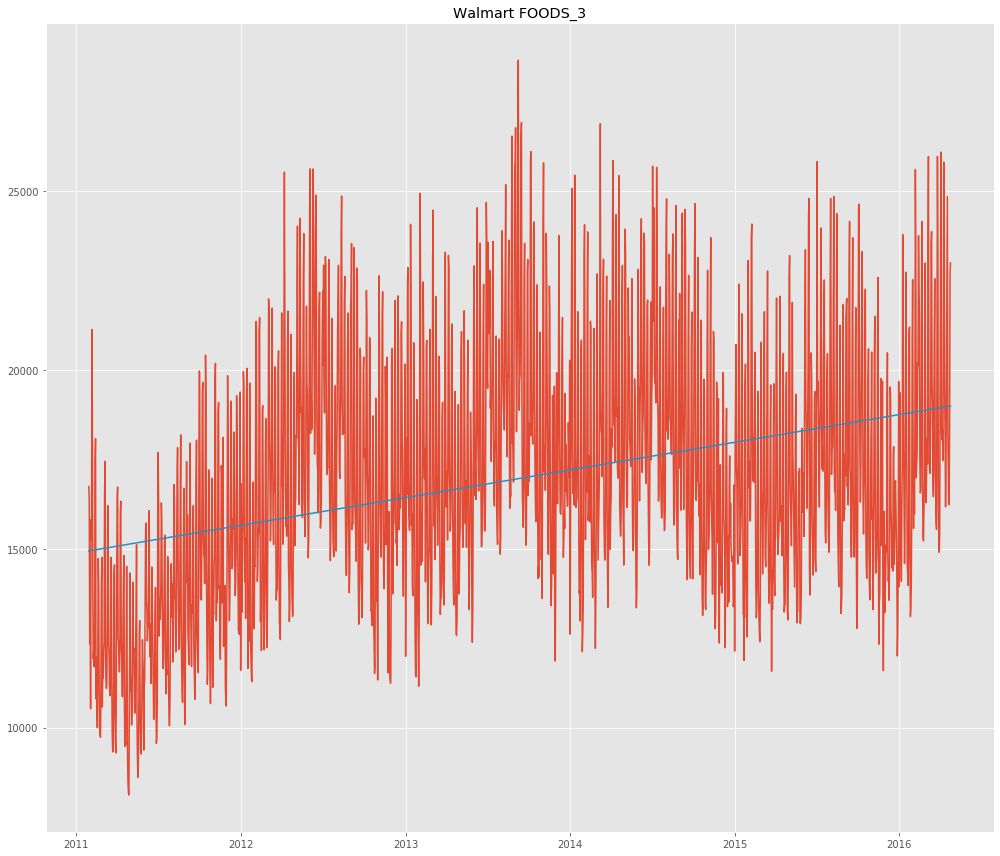

In [155]:
series = med_food3
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

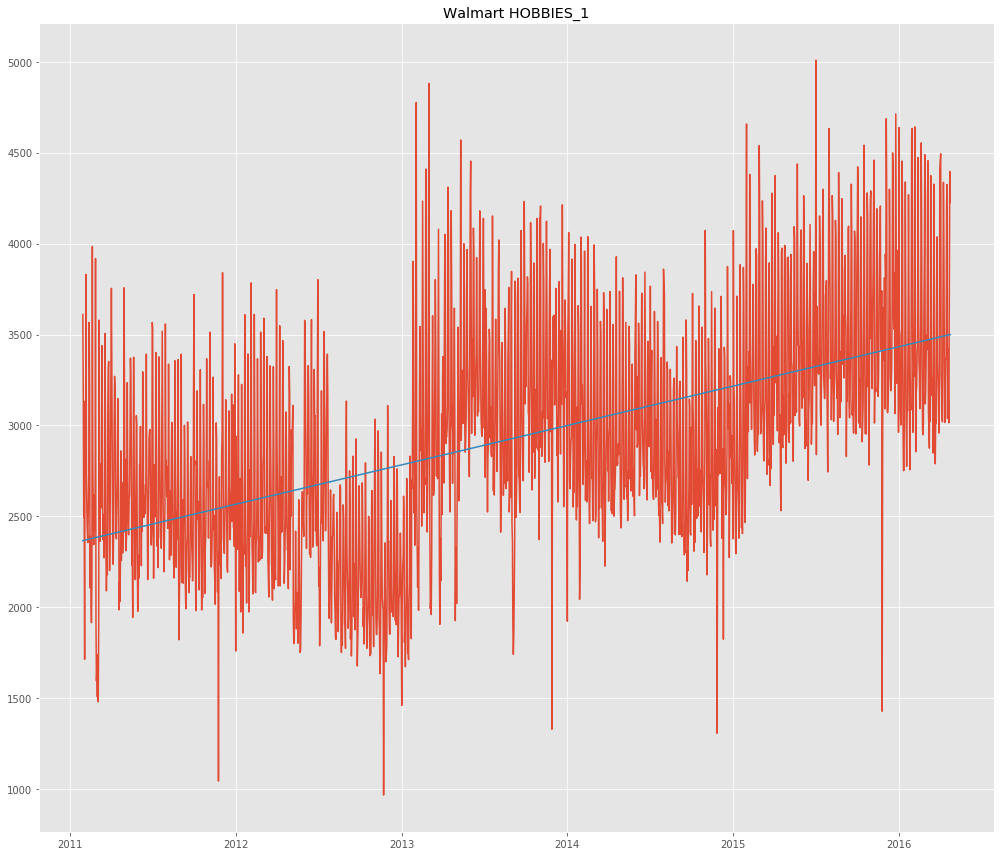

In [156]:
series = med_hobby1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

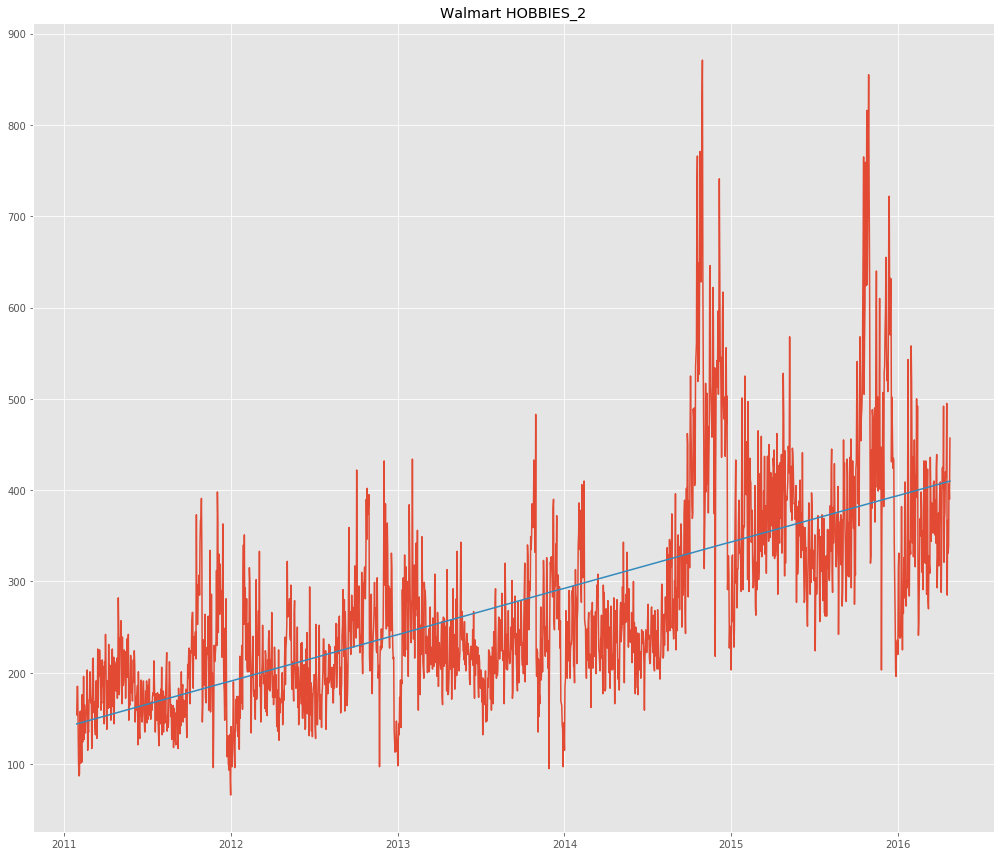

In [157]:
series = med_hobby2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

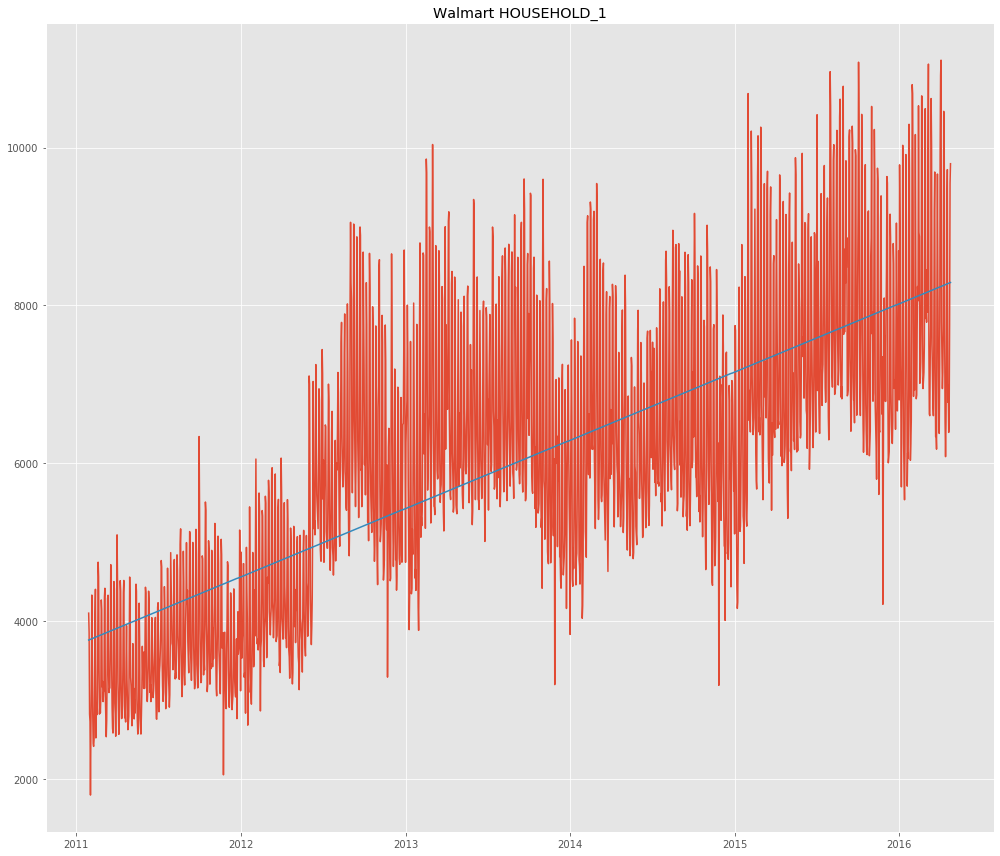

In [158]:
series = med_household1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

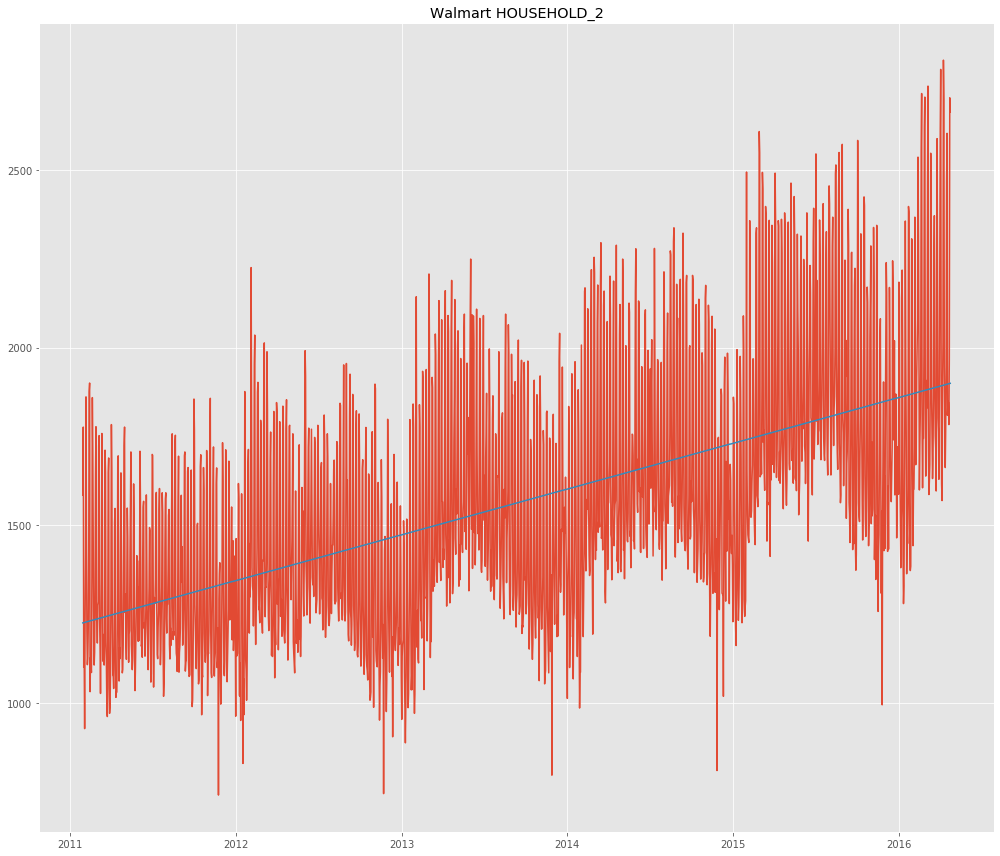

In [159]:
series = med_household2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

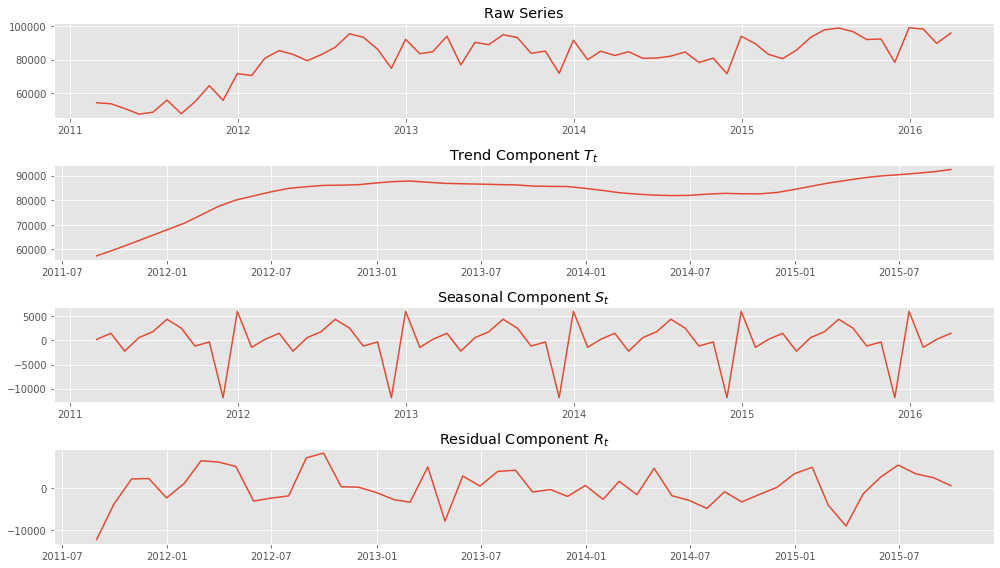

In [166]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food1, 'M'))
plt.tight_layout()

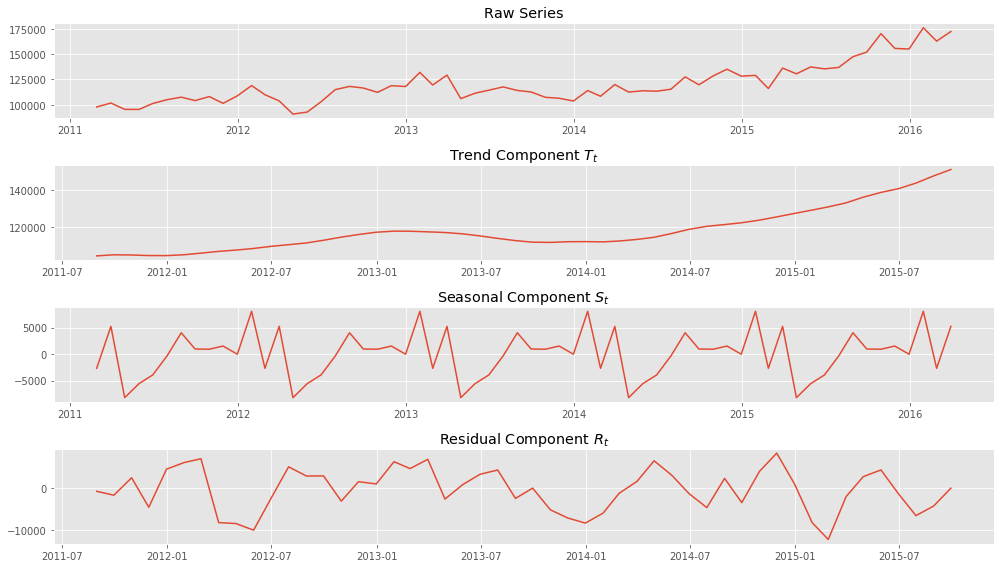

In [167]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food2, 'M'))
plt.tight_layout()

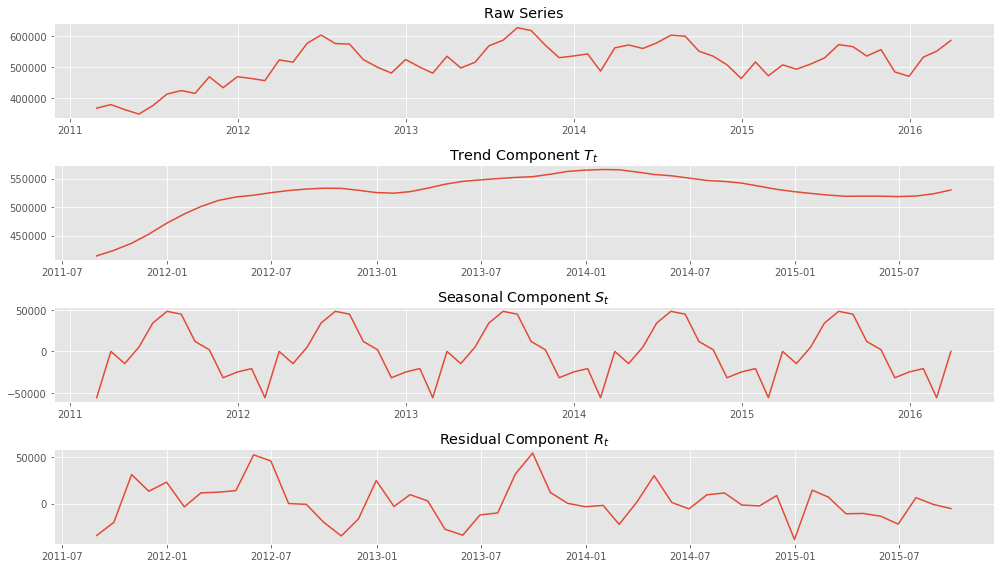

In [168]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food3, 'M'))
plt.tight_layout()

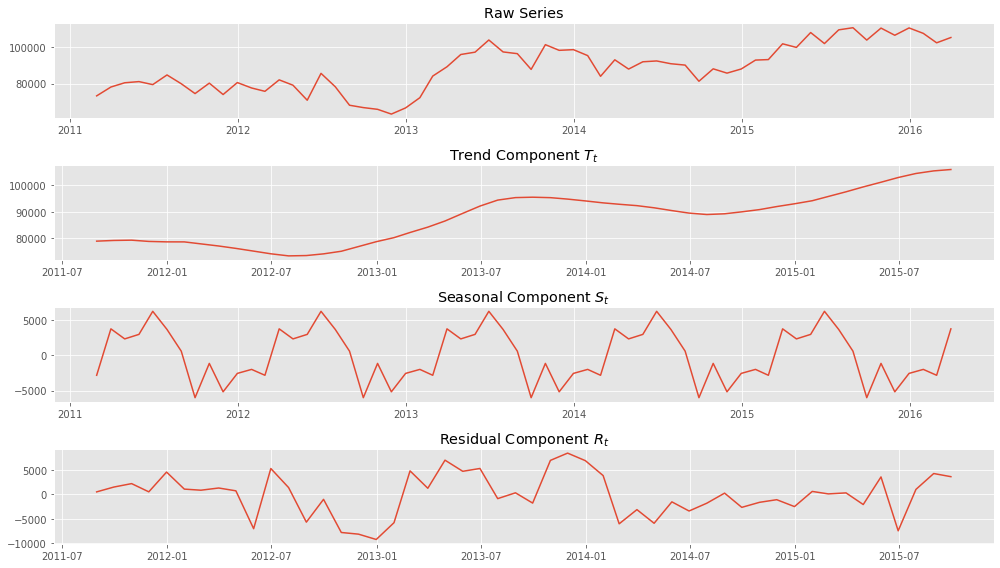

In [169]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_hobby1, 'M'))
plt.tight_layout()

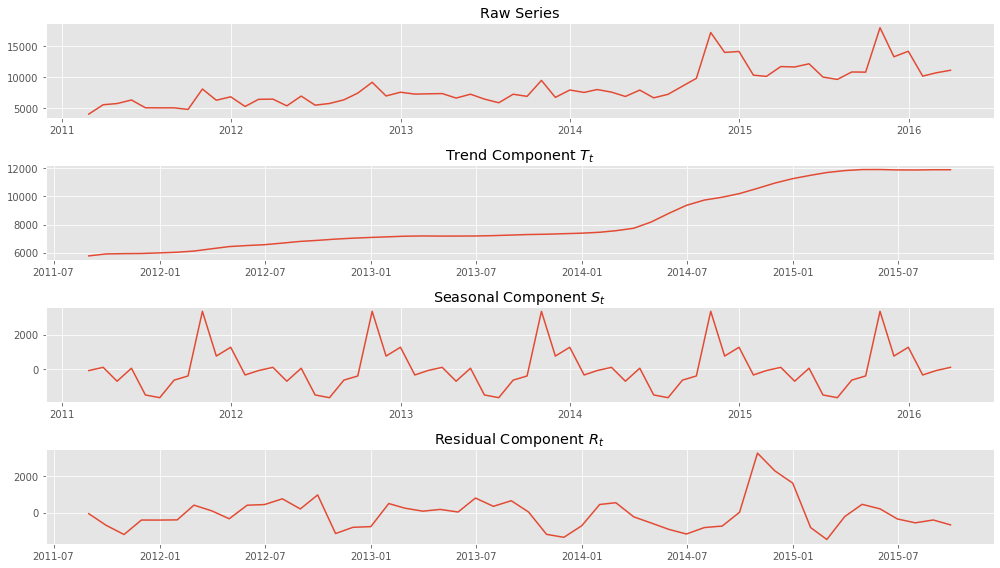

In [170]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_hobby2, 'M'))
plt.tight_layout()

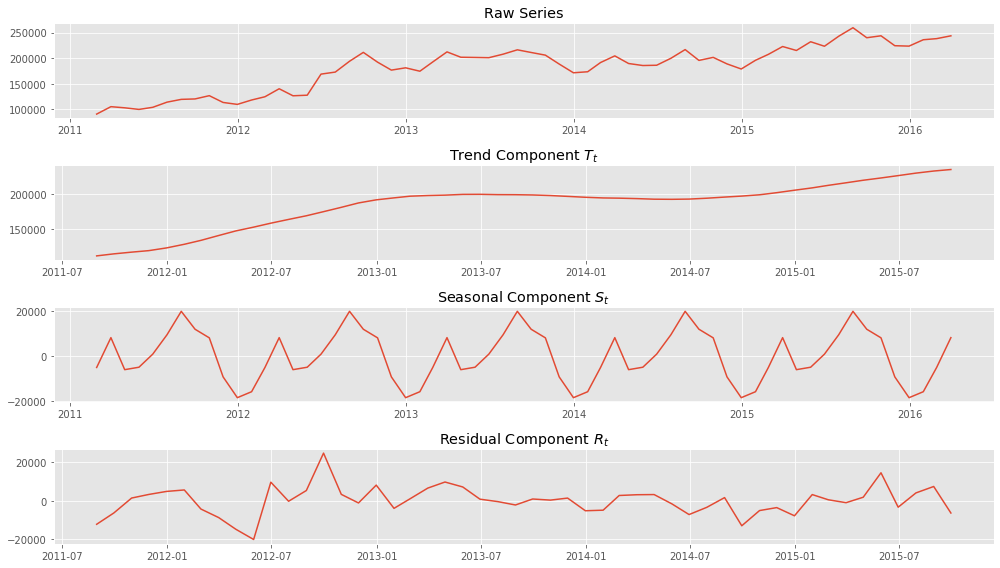

In [171]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_household1, 'M'))
plt.tight_layout()

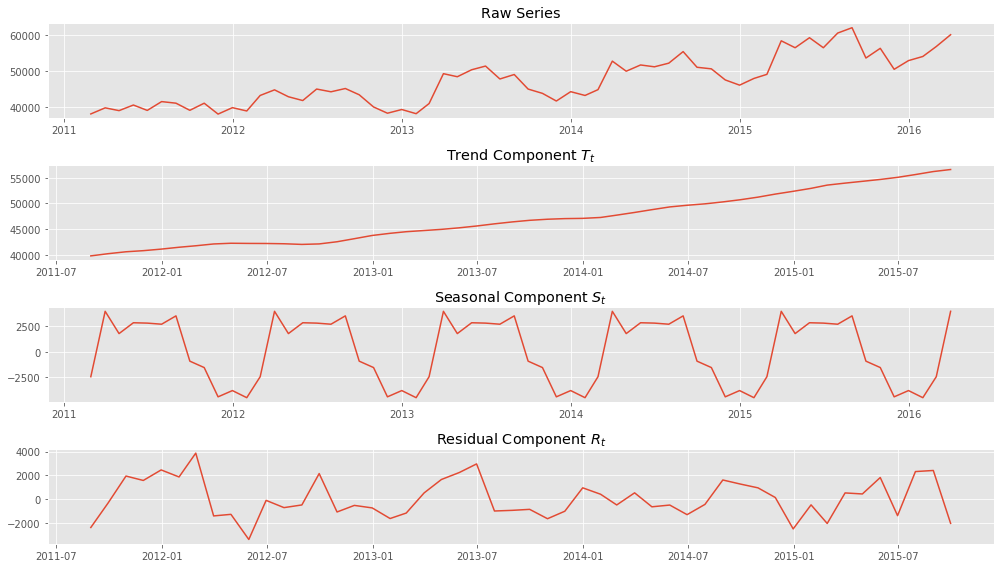

In [172]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_household2, 'M'))
plt.tight_layout()

In [ ]:
#maybe make some decisions about where to cut data to get a better trend line? Start looking at forecasting?
#to forecast an individual product, perhaps forecast on the entire category, then break down by % in sub category,
#then break it down by percent in each item.
# Need to figure out how to forecast trend line into future.
#Household2 looks pretty consistent, might need to chop other ones? Hard to say.